Moment vs T and general functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.optimize as scop
import csv  
import matplotlib as mpl
#import seaborn as sns
#import Stoner

#THIS BLOCK Sanitises THE DATA AND CONVERTS IT FROM CGS TO SI UNITS IF REQUIRED 


#Filepath where the point the test datafile exists in so it can be accessed
#C:\Users\thoma\Documents\Physics Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.csv
#C:\Users\thoma\Documents\Physics_Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\Rotator\TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat
filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
#file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"

file = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
#C:\Users\thoma\Documents\Physics_Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.dat
FILEANDPATH=filepath+file

#print(FILEANDPATH)

Labels = ['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)' ]
#print(FILEANDPATH)


#The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
#accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
index_of_headers = 0
for i in range(100):
    try:
        df_raw_data = pandas.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
        print("headers start on line", i,)
        #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
        # found not to format the columns correctly
        index_of_headers = int(i+1)
        break
    except:
        None
        #print("headers don't start on line", i,)
    
#print(index_of_headers)

#new dataframe using the index for headers we found
df_raw_data = pandas.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


#drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
df_sanitised_once_data = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)

''' can sanitise again to make and NaN values the previous using .ffill, can make the graph pretty ugly and wrong, but it does make the lines join up, if you care'''
#df_sanitised_once_data = df_raw_data.ffill()


'''need to have a part here that gets the time stamp column and sets it to 0 each time!'''

#Take information such as if data should be left as cgs or converted to si or if the sample was field cooled or zero field cooled for 
#plotting titles of the graphs
fc_or_zfc = 'zfc'
fc_or_zfc = fc_or_zfc.upper()
cgs_or_si = 'cgs'
field = '0.1T'

# Display the filtered dataframe


start_time = df_sanitised_once_data.loc[0,'Time Stamp (sec)']
#print(start_time)
#print(df_sanitised_once_data['Time Stamp (sec)'])
#df_sanitised_once_data = df_sanitised_once_data['Time Stamp (sec)']-29491894

if cgs_or_si.lower() == "cgs":
    print("CGS, units accepted")
    df_sanitised_cgs =df_sanitised_once_data.copy()
    df_name = df_sanitised_cgs
elif cgs_or_si.lower() == "si":
    print("SI, units accepted")
    
    #create a new df containing the sanitised data in correct units
    df_sanitised_si =df_sanitised_once_data.copy()
    df_sanitised_si['Magnetic Field (Oe)']=df_sanitised_si['Magnetic Field (Oe)']*0.0001
    df_sanitised_si['Moment (emu)']=df_sanitised_si['Moment (emu)']*10**(-3)

    '''More variables can be placed here and then renamed below if used, so far only M-field and Moment have been plotted by me'''

    #rename column names to reflect the new units
    df_sanitised_si.rename(columns ={"Magnetic Field (Oe)": "Magnetic Field (T)", "Moment (emu)":"Moment (Am^2)"}, inplace = True)
    df_name = df_sanitised_si
else: 
    print("Invalid Input. Try again")

print(f"Remaining Column Headers are: {df_name.columns}")

#The below is to put limits on the plots for temperature, comment out if you want the full plot
lower_temp = 0
higher_temp = 300
df_temperature_range = df_name[(df_name['Temperature (K)'] >= lower_temp) & (df_name['Temperature (K)'] <= higher_temp)]


#print(f"{df_raw_data.columns}")

#df_name


headers start on line 43
CGS, units accepted
Remaining Column Headers are: Index(['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Transport Action', 'Center Position (mm)', 'Range',
       'Min. Temperature (K)', 'Max. Temperature (K)', 'Min. Field (Oe)',
       'Max. Field (Oe)', 'Pressure (Torr)', 'Measurement Number',
       'SQUID Status (code)', 'Motor Status (code)', 'Measure Status (code)',
       'Motor Current (amps)', 'Motor Temp. (C)', 'Temp. Status (code)',
       'Field Status (code)', 'Chamber Status (code)', 'Chamber Temp (K)',
       'Redirection State', 'Average Temp (K)', 'Rotation Angle (deg)',
       'Rotator state', 'DC Moment Fixed Ctr (emu)',
       'DC Moment Err Fixed Ctr (emu)', 'DC Moment Free Ctr (emu)',
       'DC Moment Err Free Ctr (emu)', 'DC Fixed Fit', 'DC Free Fit',
       'DC Calculated Center (mm)', 'DC Calculated Center Err (mm)',
       'DC Scan Length (mm)', 'DC Scan Time (s)', 'DC Number of Points',
       'DC Squid Drift',

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure

#THIS BLOCK CONTAINS FUNCTIONS USED FOR PLOTTING 


#function that plots the desired data, x vs y. Can use this function to handle several common plot requests 
def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                  facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()


#several other functions to plot the requested two variables!

def plot_mom_vs_temp(df, sample, field, fc_or_zfc):
    #use a try except block to allow the function to deal with data in either form
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Temperature (K)', 'Moment (emu)', title)
        except: 
            print('error')
            '''
            title=f"Moment(Am^2) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df,'Temperature (K)', 'Moment (Am^2)', title)
'''
def plot_mom_vs_field(df, sample, field, fc_or_zfc):
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Magnetic Field(Oe) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (Oe)','Moment (emu)', title)
        except: 
            title=f"Moment(Am^2) vs Magnetic Field(T) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (T)','Moment (Am^2)', title)
    

    '''non completed functions below'''
def plot_rawmag_vs_T(df, sample, field, fc_or_zfc):
    title =f"Raw Magnetisation (emu) vs Temperature (K) for {sample} at {field}, {fc_or_zfc}"
    plot_data(df,'Temperature (K)', 'M. Raw\' (emu)', title)
    


    #work on plotting to beautify them, make them level of a paper, make a separate plot function for pretty plots. make plots readable
    #Take data from additional csv's and overlay them
    #data analysis, use HTE code or plot Low temp behavior 
    #other packages around plotting like seaborn could be good
    #detect anomalies, what do we want from this data.
    #how can this be more flexible?
    #add utility and exercise

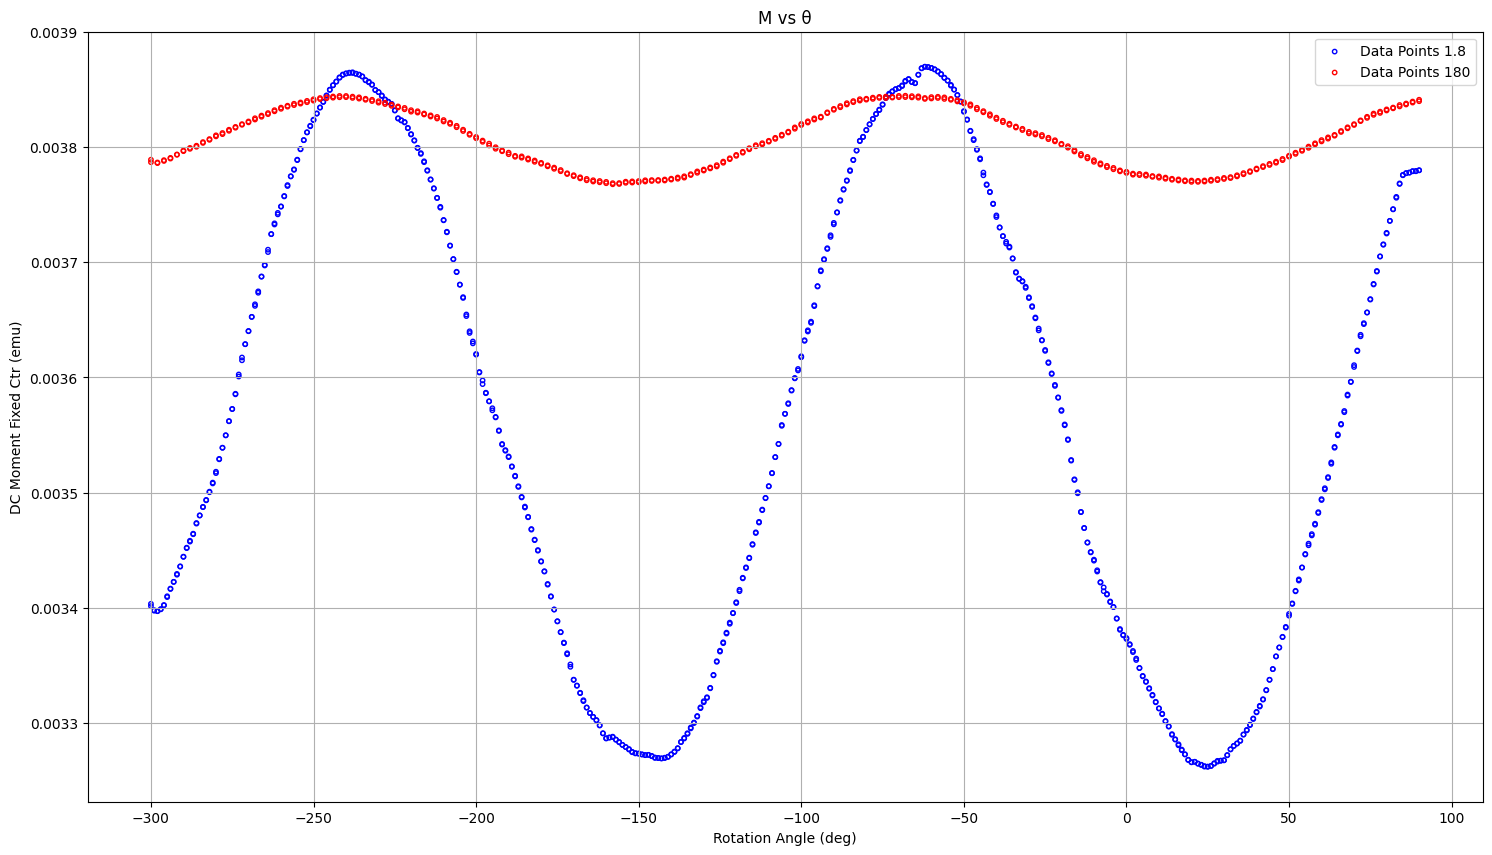

In [10]:

def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                  facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()

def ang_offset(x, offset=300):
    return (x+offset)

def vert_off(y, offset = 0.003):
    return(y+offset)

filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
#file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"

file1 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
file2 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_180K.dat"
#C:\Users\thoma\Documents\Physics_Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.dat

FILEANDPATH1=filepath+file1

FILEANDPATH2=filepath+file2

df_raw_data = pandas.read_csv(FILEANDPATH1, sep=",", skiprows= index_of_headers, encoding='unicode_escape')
df_raw_data['Rotation Angle (deg)'] = df_raw_data['Rotation Angle (deg)']


x = df_raw_data.loc[:,'Rotation Angle (deg)']
y = df_raw_data.loc[:,'DC Moment Fixed Ctr (emu)']
sorted_df = df_raw_data.sort_values(by='Rotation Angle (deg)')
#print(sorted_df)
x_sorted = sorted_df.loc[:,'Rotation Angle (deg)']
y_sorted = sorted_df.loc[:,'DC Moment Fixed Ctr (emu)']
fig = figure(figsize=(18,10))
plt.scatter(x, y, s=10, 
            #c='r', 
                facecolors='none', edgecolors= 'b', label = 'Data Points 1.8')
#plt.plot(x, y, c='r', linewidth=0.8)


#second plot
df_raw_data = pandas.read_csv(FILEANDPATH2, sep=",", skiprows= index_of_headers, encoding='unicode_escape')
df_raw_data['DC Moment Fixed Ctr (emu)'] = df_raw_data['DC Moment Fixed Ctr (emu)'].apply(vert_off)


x = df_raw_data.loc[:,'Rotation Angle (deg)']
y = df_raw_data.loc[:,'DC Moment Fixed Ctr (emu)']
sorted_df = df_raw_data.sort_values(by='Rotation Angle (deg)')
#print(sorted_df)
x_sorted = sorted_df.loc[:,'Rotation Angle (deg)']
y_sorted = sorted_df.loc[:,'DC Moment Fixed Ctr (emu)']
#fig = figure(figsize=(18,10))
#

plt.scatter(x, y, s=10, 
            #c='r', 
                facecolors='none', edgecolors= 'r', label = 'Data Points 180')
#plt.plot(x, y, c='r', linewidth=0.8)
plt.title('M vs θ')
plt.xlabel('Rotation Angle (deg)')
plt.ylabel('DC Moment Fixed Ctr (emu)')
#plt.xlim(0,360)
plt.grid('both')
plt.legend()
plt.show()

#plot_data(df_raw_data, 'Rotation Angle (deg)', 'DC Moment Fixed Ctr (emu)', 'M vs θ')




In [4]:
#sample = 'RuCl3'
#plot_mom_vs_temp(df_temperature_range, sample, field, fc_or_zfc)


#Namba paperData
#df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
df_ref = pd.read_csv("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')


x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y*1000#to put as 10^-3

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)
x2 = df_temperature_range.loc[:,'Temperature (K)']
y2 = df_temperature_range.loc[:,'Moment (emu)']

x2 = x2
y2 = y2*conversion_factor*1000#to put as 10^-3

fig = figure(figsize=(18,10))

plt.scatter(x1, y1, s=10, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = 'Namba\'s data Points')
plt.scatter(x2, y2, s=10, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = 'Our data')
    #plt.plot(x, y, c='r', linewidth=0.8)
plt.xlim(0, 20)
plt.ylim(bottom = 15)
plt.title('RuCl3 TB001 magnetic χ vs Namba Crystal')
#plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\chi$ ($10^{-3}$emu/mol)')
plt.grid('both')
plt.legend()
plt.show()

6.285757575757576


KeyError: 'Moment (emu)'

Heat Capacity Plotting


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
import csv
import matplotlib as mpl
#import seaborn as sns
#import Stoner


filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
#filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
file = "RuCl3_TB001_HeatCapacity_1.csv"

def HC_PPMS_data_loading(input_filepath):
    
    '''
    function that takes an input file that is a csv and deals with the annoying PPMS header information. can be used to load in multiple csv's via it being a function 
    input_filepath = full filepath of the file desired. in the format of '/' instead of '\'
    
    '''
    #Filepath where the point the test datafile exists in so it can be accessed
    FILEANDPATH=input_filepath
    
    #N.B. Heat capacity uses 'Time Stamp (Seconds)' which is different to regular PPMS data files
    Labels = ['Time Stamp (Seconds)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)', 'Samp HC (J/mole-K)', 'Sample Coupling (Percent)']
    
    #The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
    #accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
    #index_of_headers = 0
    for i in range(100):
        try:
            df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
            print("headers start on line", i,)
            #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
            # found not to format the columns correctly
            index_of_headers = int(i+1)
            break
        except:
            None
            #print("headers don't start on line", i,)
    #new dataframe using the index for headers we found
    df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


    #drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
    df_name = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)
    print(f"Remaining Column Headers are: {df_name.columns}")
    return(df_name)




In [ ]:
'Samp HC (J/mole-K)'

import pandas as pd
import os

'''
#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_data_HC.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']

x1 = x
y1 = y
'''

#our data

sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol

#9T HC
'''
HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")
#HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")

x1 = HC_9T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y1 = HC_9T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y1err=HC_9T_RuCl3['Samp HC Err (J/mole-K)']
'''

#0T HC
HC_0T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HeatCapacity_1.csv")
#HC_0T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HeatCapacity_1.csv")

x2 = HC_0T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y2 = HC_0T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y2err=HC_0T_RuCl3['Samp HC Err (J/mole-K)']

#0T HC later
HC_0T_RuCl3_2 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/28-03-2025_RuCl3_TB001_0T _001_300-3K.csv")
#HC_0T_RuCl3_2 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/28-03-2025_RuCl3_TB001_0T _001_300-3K.csv")

x3 = HC_0T_RuCl3_2.loc[:,'Sample Temp (Kelvin)']
y3 = HC_0T_RuCl3_2.loc[:,'Samp HC (J/mole-K)']
y3err=HC_0T_RuCl3_2['Samp HC Err (J/mole-K)']



#get Specific heat capacity = C/T

y1 = y1/x1
y2 = y2/x2
y3 = y3/x3
fig = figure(figsize=(18,10))

'''
plt.scatter(x1, y1, s=50, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = '9T HC')
                
#plt.errorbar(x1, y1, yerr=y1err,capsize=4,                    # little cap on the error bar
    #ecolor='gray',                # color of error bars
    #elinewidth=1.2,
    #markerfacecolor='blue')

plt.plot(x1, y1, c='b', linewidth=0.8)
'''



plt.scatter(x2, y2, marker='o', s=50, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = '0T HC')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

plt.plot(x2, y2, c='r', linewidth=0.8)

'''
plt.scatter(x3, y3, marker='o', s=50, 
                #c='r', 
                facecolors='g', edgecolors= 'g', label = '0T HC Taken later')
plt.plot(x3, y3, c='g', linewidth=0.8)
'''

'''
plt.axvline(
    x=7.35,
    color='orange',
    linestyle='--',
    linewidth=1.5,
    label='Neel Temperature, 7.35 K'
)
'''
plt.xlim(0, 20)
plt.title('RuCl3 TB001 H.C.')
plt.xlabel('Sample Temperature (K)')
plt.ylabel('C/T (J/mole-K^2)')
plt.grid('both')
plt.legend()
plt.show()

In [ ]:
'Samp HC (J/mole-K)'

import pandas as pd
import os

'''
#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_data_HC.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']

x1 = x
y1 = y
'''

#our data

sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol

#9T HC

HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/07-04-2025_RuCl3_TB001_9T_ZFCW_coarse_Scan_15-300K_001.csv")
#HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")
HC_9T_RuCl3.sort_values(by=['Sample Temp (Kelvin)'])
x1 = HC_9T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y1 = HC_9T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y1err=HC_9T_RuCl3['Samp HC Err (J/mole-K)']

y2 = HC_9T_RuCl3.loc[:,'Sample Coupling (Percent)']




#get Specific heat capacity = C/T

y1 = y1/x1

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = fig.add_subplot(111)



ax.scatter(x1, y1, marker='x', s=50, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = '9T RuCl3 Heat Capacity')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

ax.plot(x1, y1, c='b', linewidth=0.8)

ax2 = ax.twinx()

ax2.scatter(x1, y2, marker='o', s=50, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = 'Sample Coupling')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

ax2.plot(x1, y2, c='r', linewidth=0.8)


plt.xlim(0, 310)
plt.title('RuCl3 TB001 H.C.')

plt.grid('both')
ax.set_xlabel('Sample Temperature (K)')
ax.set_ylabel('C/T (J/mole-K^2)')
ax2.set_ylabel('Sample Coupling (%)')
ax2.legend(loc=0)
ax.legend(loc=2)

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from your specified file path
file_path = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/red_curve_C_over_T_vs_T.csv"
df = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(df["Temperature (K)"], df["C_over_T (J/mol K^2)"], 'o', color='red', markersize=3, label='Red Curve')
# Load the data from your specified file path
file_path = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/red_curve_C_over_T_vs_T_final.csv"
df = pd.read_csv(file_path)

# Plot the data

plt.plot(df["Temperature (K)"], df["C_over_T (J/mol K^2)"], 'o', color='b', markersize=3, label='Namba\'s data Points')
###

# Labels and title
plt.xlabel("Temperature (K)")
plt.ylabel(r"$C/T$ (J mol$^{-1}$ K$^{-2}$)")
plt.title(r"Heat Capacity over Temperature vs Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()